The Photometric LSST Astronomical Time-Series Classification Challenge (PLAsTiCC) comprises a collection of synthetic multi-channel time series for the task of astronomical object classification. The initiative seeks to inspire the creation of robust classification algorithms before the project is completed, so the data is designed to mimic the data expected to be produced by the LSST. 

https://arxiv.org/abs/1810.00001
https://www.kaggle.com/c/PLAsTiCC-2018

We are, however, interested in the task of signal reconstruction more than signal classification, although a gaussian process model fitting a curve can be interpreted as a signal's feature vector by virtue of the model's parameters.

In [4]:
from model import mosm_model
import numpy as np
import csv
import time

The following functions allow us to unravel the information contained in the dataset in multioutput format.

In [5]:
def make_X_y_for_one_obj(data_of_object):
    #Since data_of_object are the rows pertaining the object
    #we merely need to represent the 6-channel info in the appropriate format
    #X has two values: [channel_id, mjd], where channel_id goes from 0 to 5
    #y has one value: [flux]
    X = np.zeros((data_of_object.shape[0],2))
    y = np.zeros(data_of_object.shape[0])
    counter = 0
    for row in data_of_object:
        X[counter,0] = row['band']
        X[counter,1] = row['mjd']
        y[counter] = row['flux']
        counter = counter + 1
    return X,y[:, None]

def make_X_y_matrices(path):
    with open(path, 'r') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        row_size = len(next(reader)) #This is the header row, no need to re-read it or add it to data
        size = (sum(1 for row in csvfile))
        print("size ", size)
        #For now we'll be using float32, but if more precision is needed it can be changed to 64
        #We're using a structured array to benefit from np.sort's sorting by order, this will facilitate the separation of
        #time series per stellar object.
        data = np.zeros(size, dtype={'names':('id', 'mjd', 'band', 'flux', 'flux_err', 'detected'), 'formats': (int, np.float32, int, np.float32, np.float32, int)})
        counter = 0
        csvfile.seek(0)
        next(reader)
        print(reader)
        for row in reader:
            data[counter][0] = row[0] #id
            data[counter][1] = row[1] #mjd
            data[counter][2] = row[2] #band
            data[counter][3] = row[3] #flux
            data[counter][4] = row[4] #flux_err
            data[counter][5] = row[5] #detected
            counter = counter + 1
            

        data = np.sort(data, order=['id', 'band', 'mjd']) #We sort each object by band and date, this allows us to plot easily in the model.
        X_y_of_each_object = []
        start = 0
        end = 0
        current_object = data[0]['id']
        for row in data:
            if(row['id'] != current_object):
                X_y_of_each_object.append(make_X_y_for_one_obj(data[start:end]))
                start = end + 1
                current_object = row['id']
            end = end + 1
        X_y_of_each_object.append(make_X_y_for_one_obj(data[start:end])) #Last object will not find a different one
        return X_y_of_each_object

X_y_of_each_object = make_X_y_matrices('./data/PLAsTiCC/training_set.csv') #We cast the dataset into X,y elements.

size  1421705


As in the smarphone dataset examples, we'll take the curves of one object and proceed to delete portions of the signals to test the model's reconstruction capabilities.

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 769.279699
  Number of iterations: 1000
  Number of functions evaluations: 1095


INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 769.279699
  Number of iterations: 1000
  Number of functions evaluations: 1095


Total time:  354.9420745372772


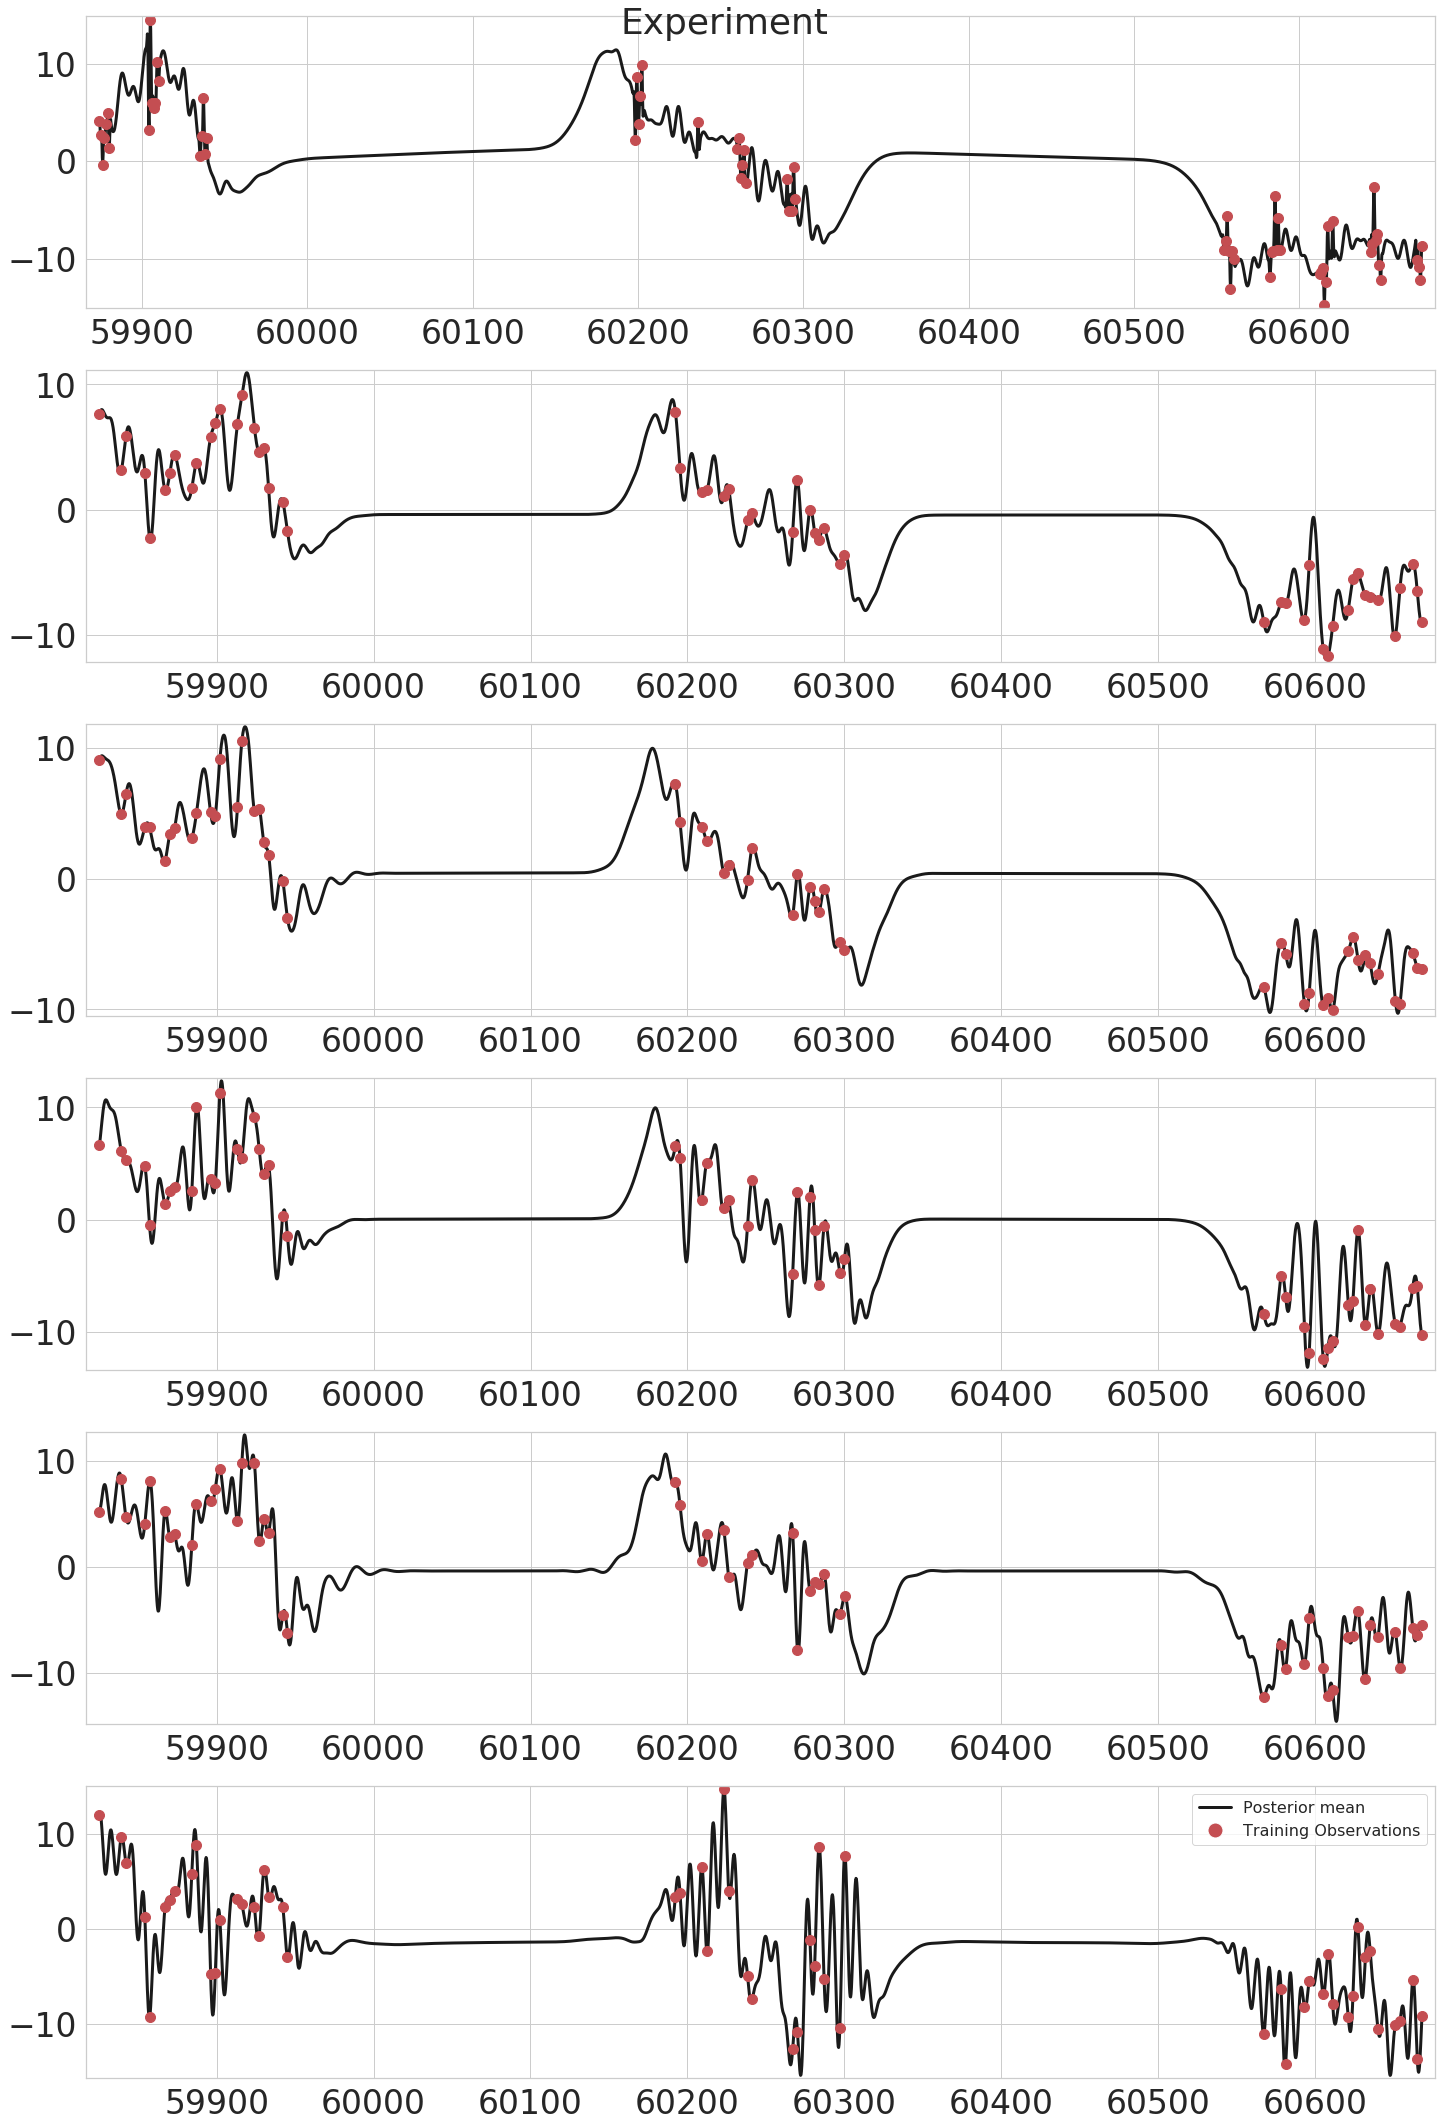

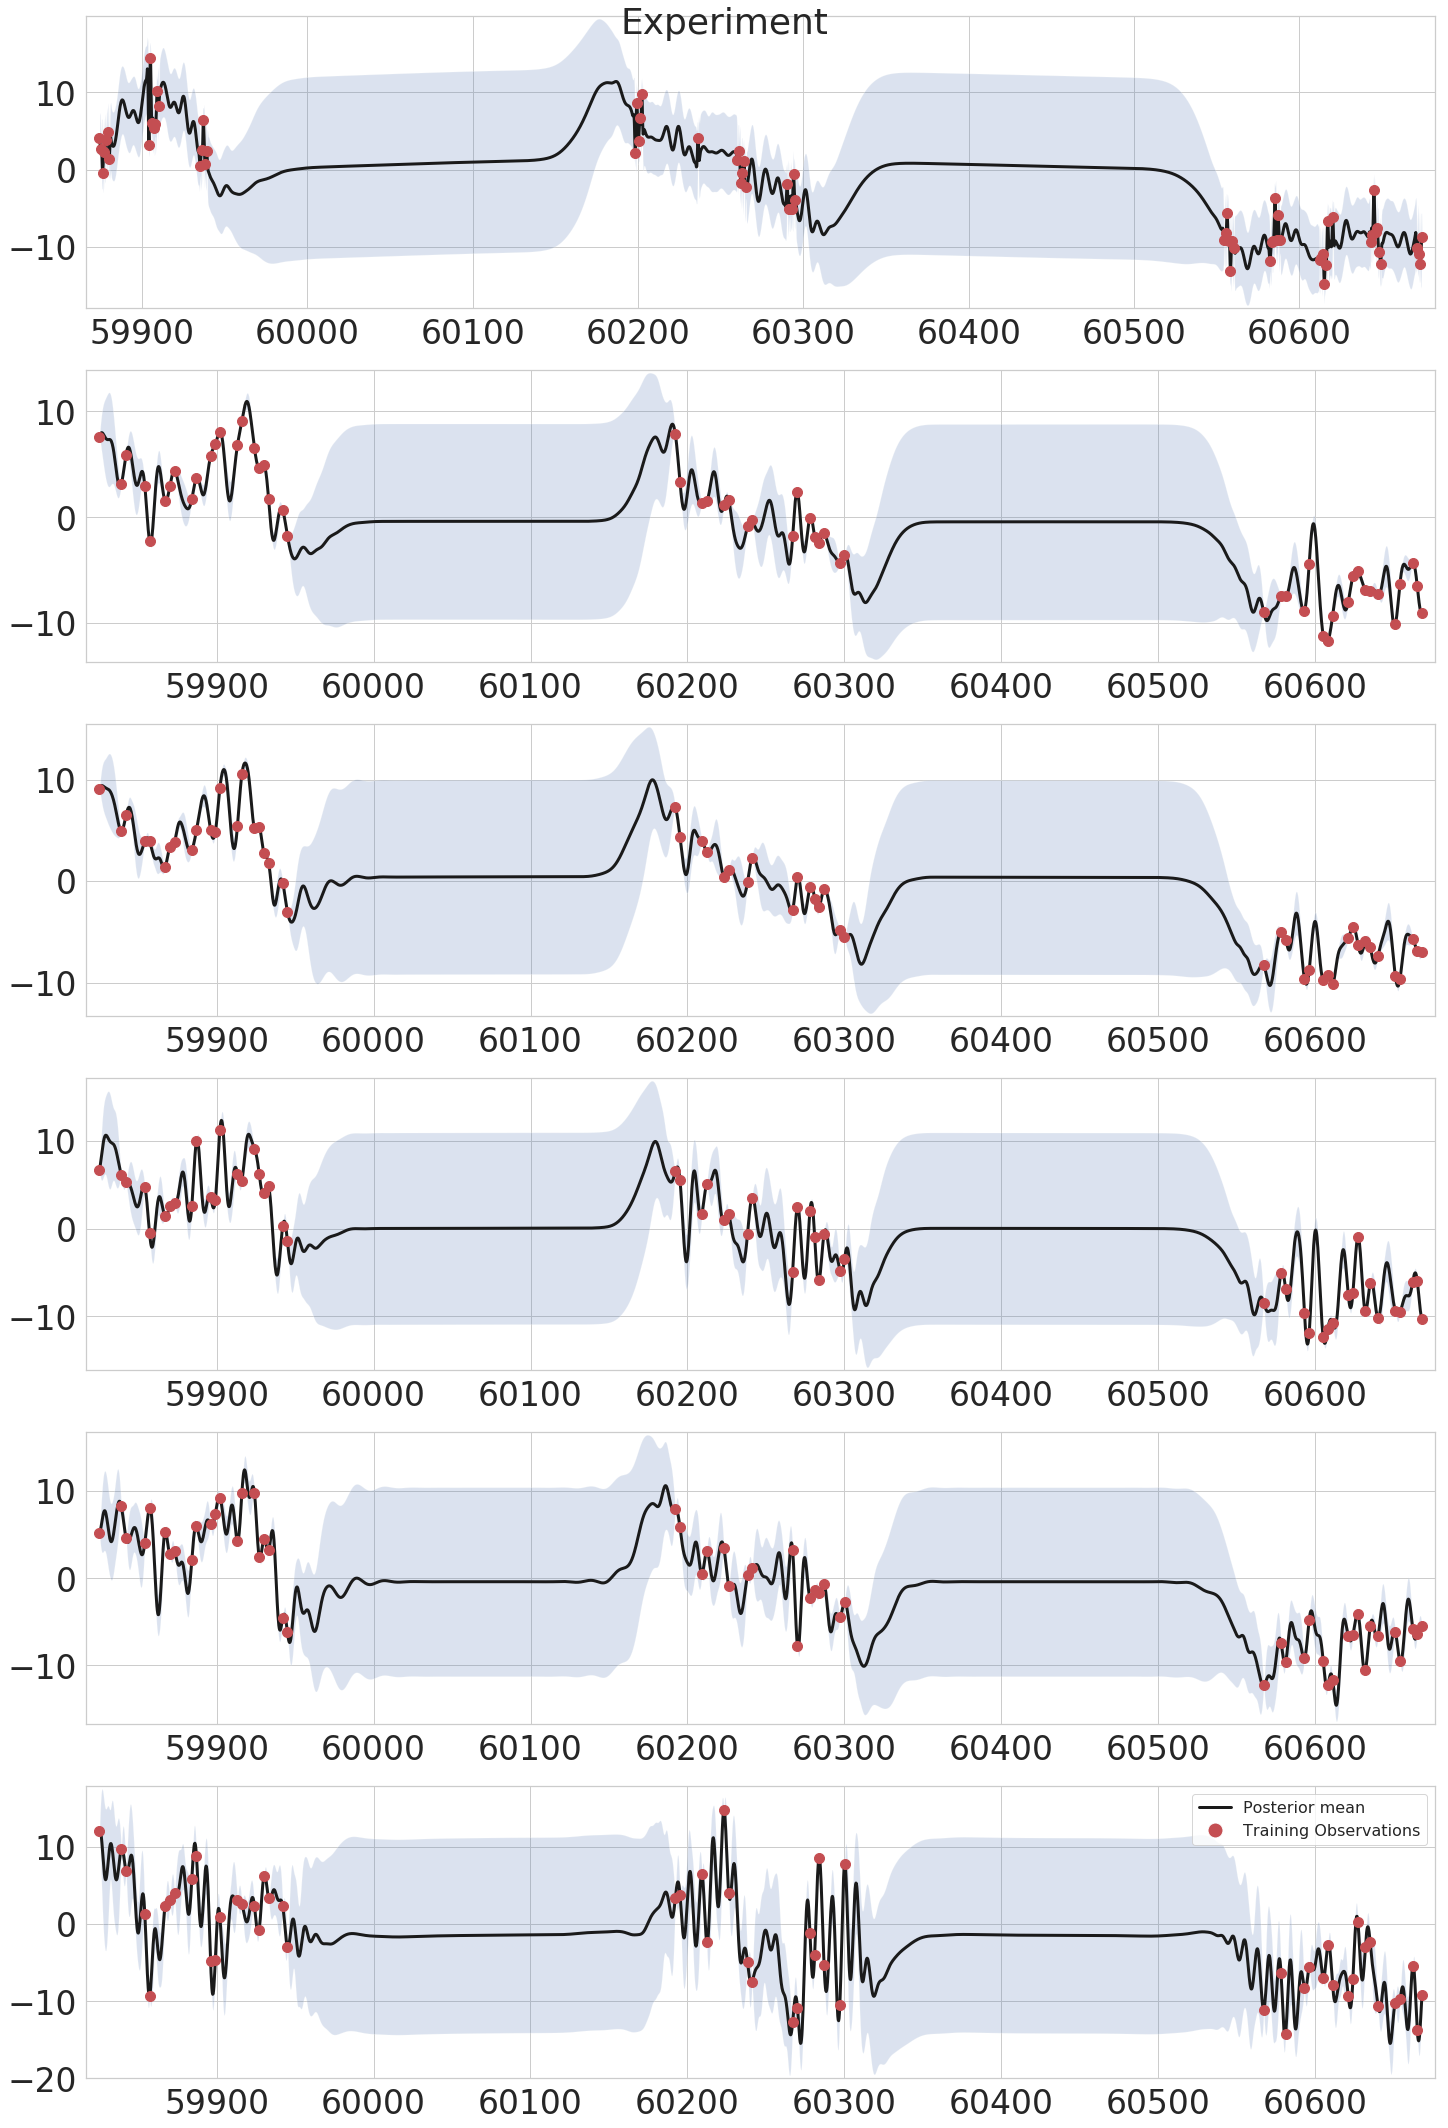

In [6]:
#Example for the first astronomical object of id 615
starting_time = time.time()
X, y = X_y_of_each_object[1]

model = mosm_model(5, optimizer = 'L-BFGS-B') #Powell takes a couple hours to compute, but always converges.
model.add_training_data(X, y)
model.optimization_heuristic_zero(iterations=1000)
X_pred_new = model.predict_interval(3200, [i for i in range(6)]) #First argument is the desired resolution (number of points between start and ending point), second argument are the desired channels to predict upon.
Y_pred, STD_pred = model.predict(X_pred_new)
model.make_plots("PLAsTiCC_example_1.png", var=False) #Variance is not included in the plot because it is too high.
model.make_plots("PLAsTiCC_example_1_no_var.png", var=True) #Variance is not included in the plot because it is too high.
end_time = time.time()
print("Total time: ", end_time-starting_time)

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 890.331064
  Number of iterations: 1000
  Number of functions evaluations: 1126


INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 890.331064
  Number of iterations: 1000
  Number of functions evaluations: 1126


Total time:  430.4246952533722


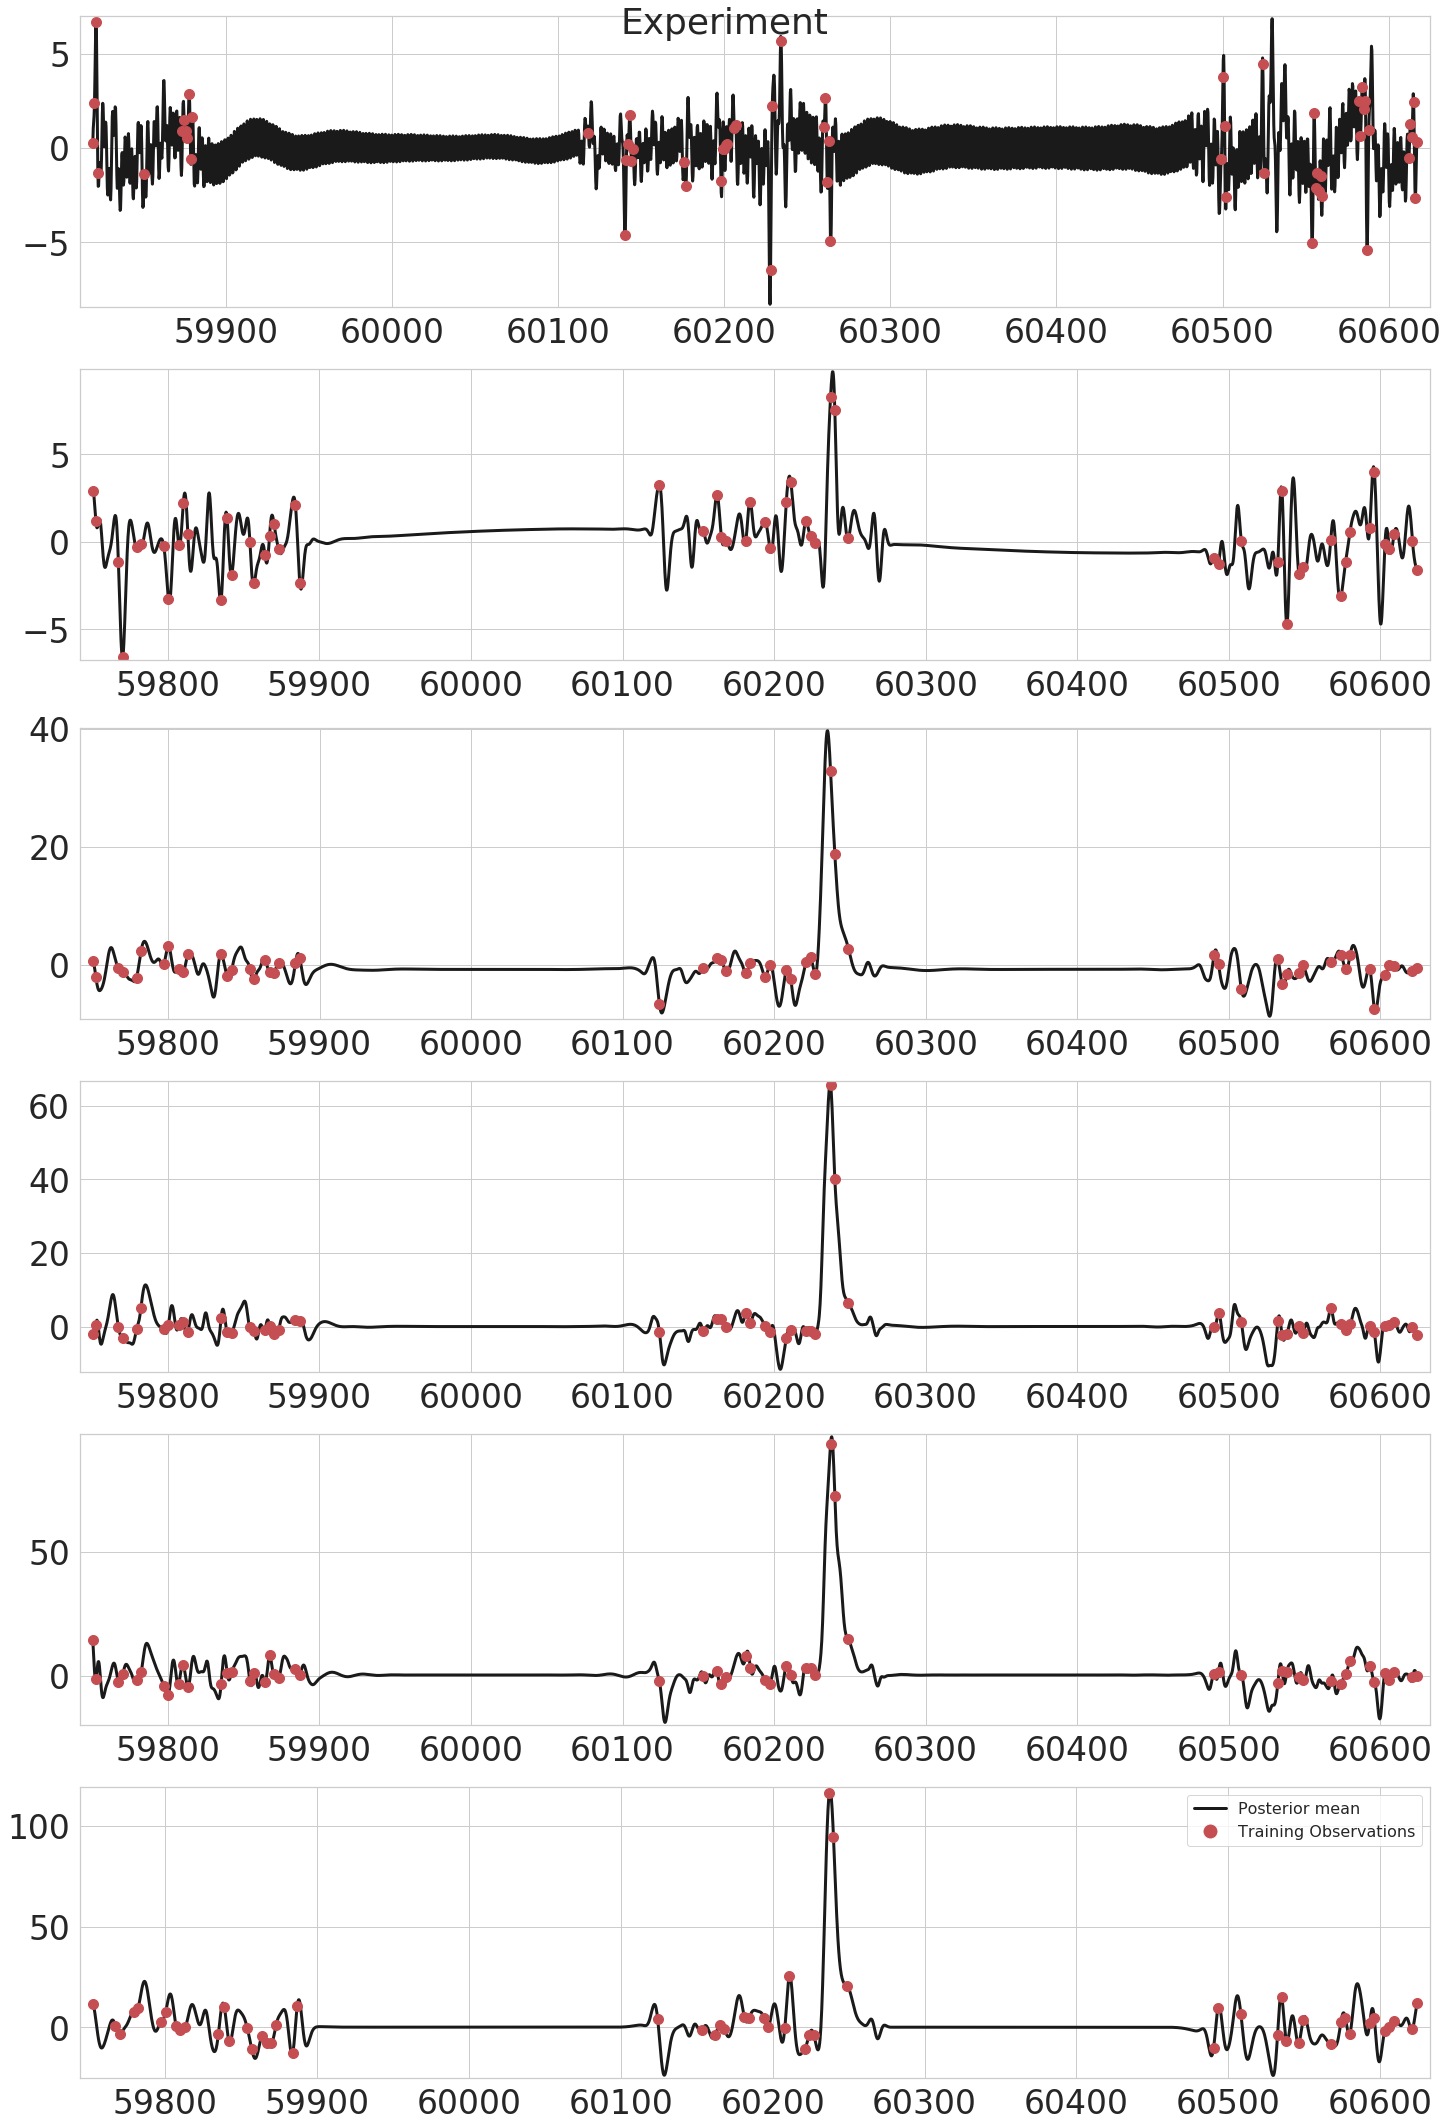

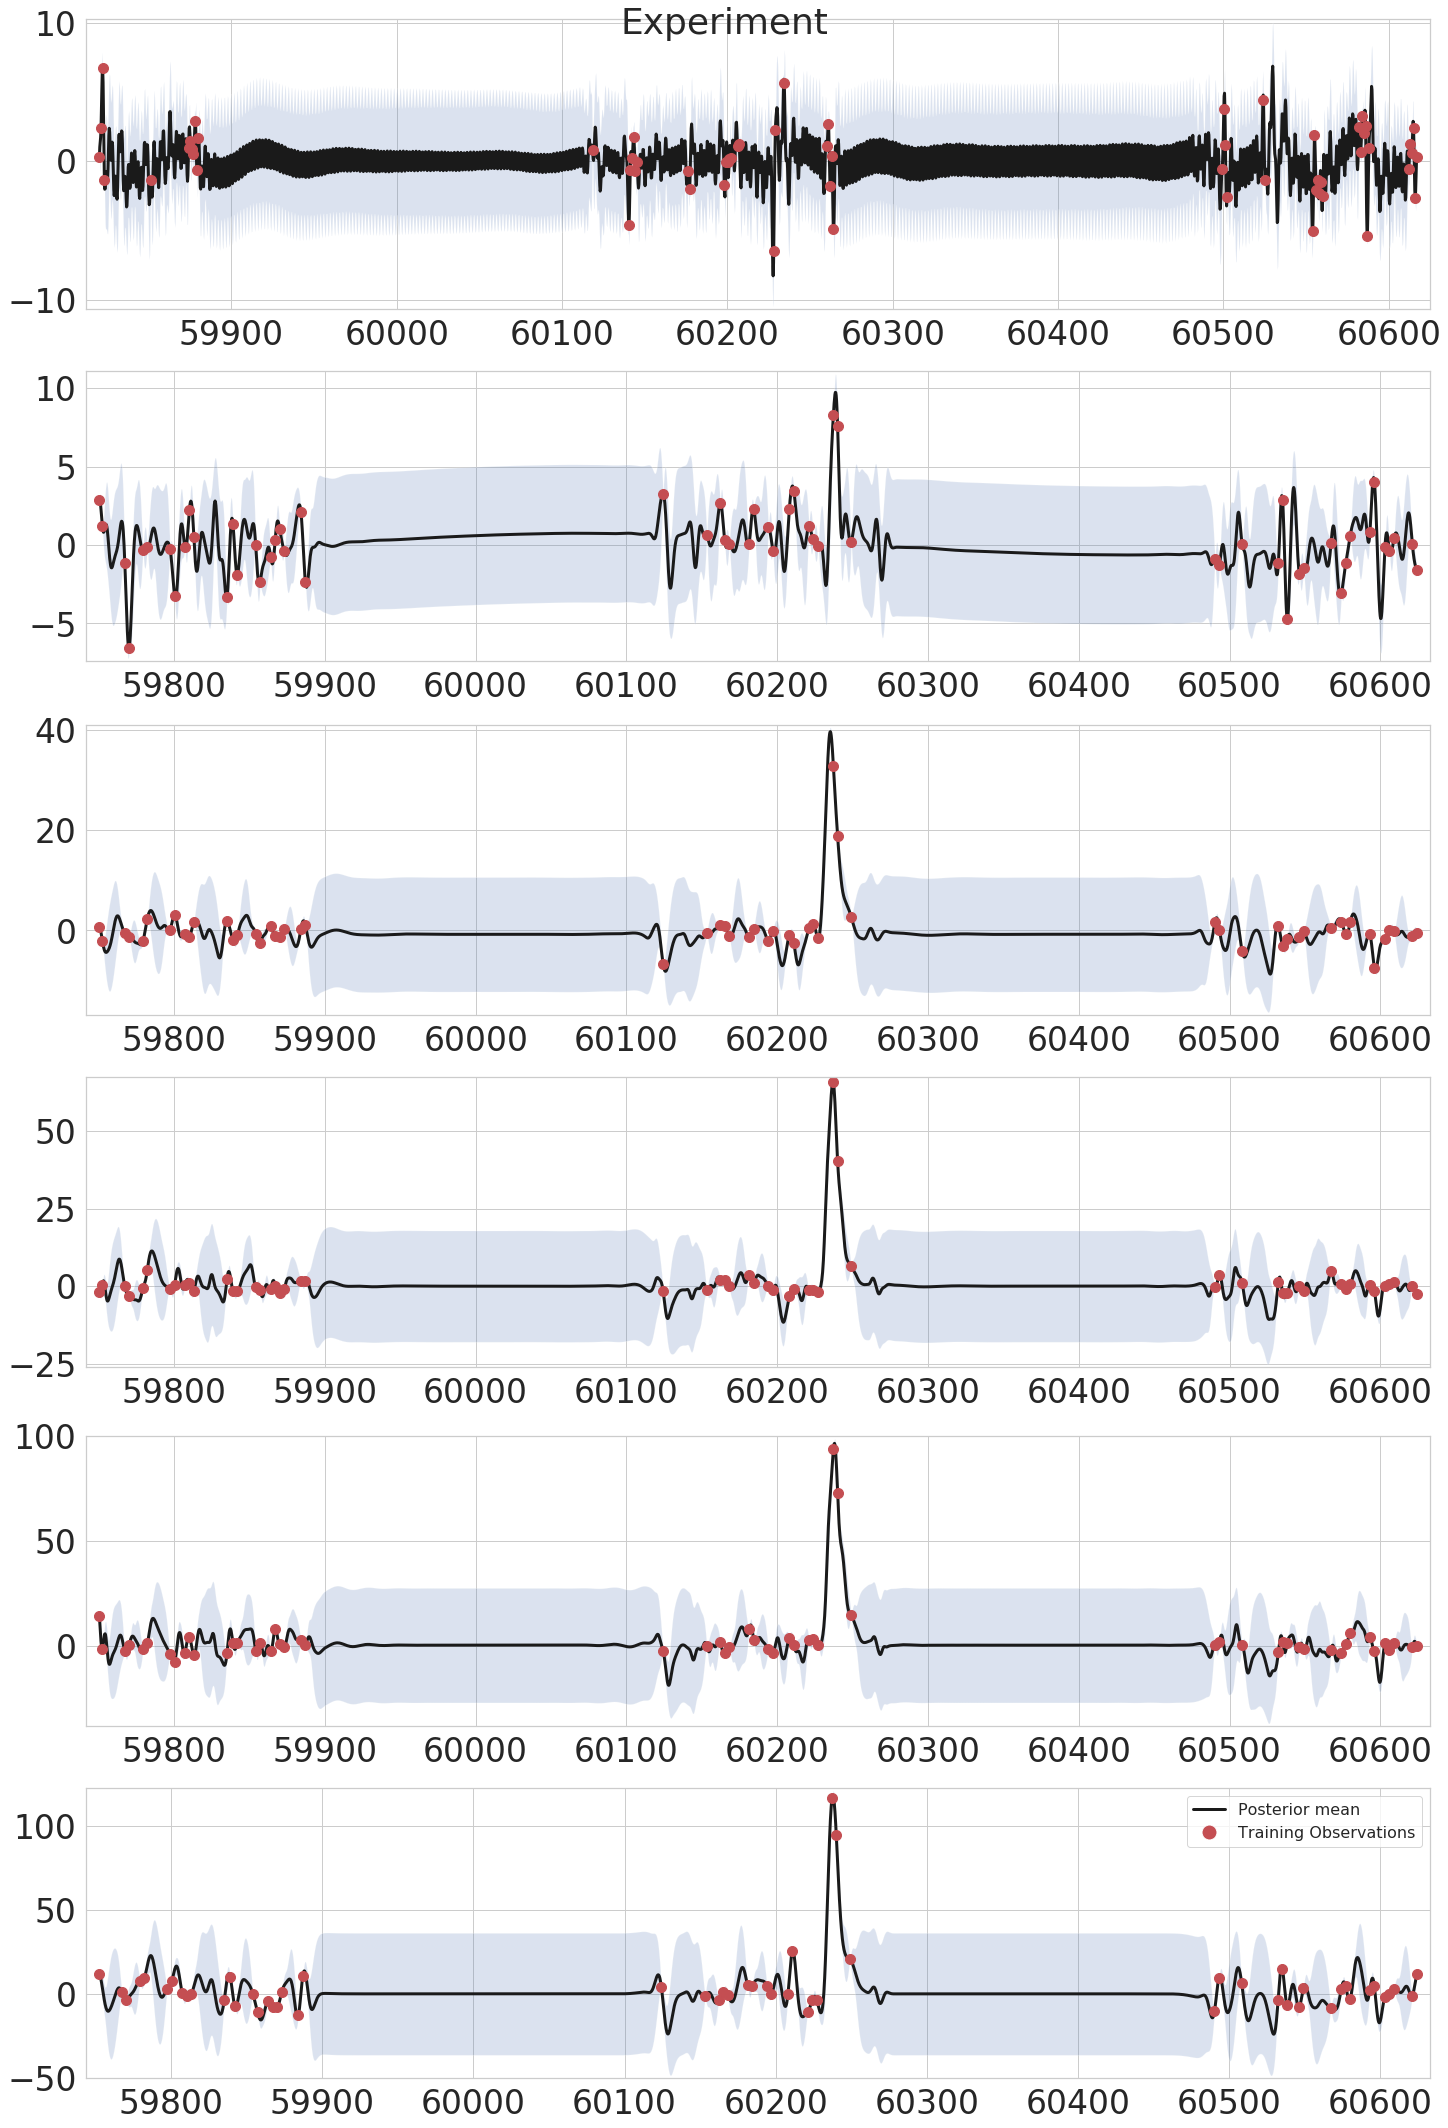

In [7]:
#Example for another astronomical object
starting_time = time.time()
X, y = X_y_of_each_object[65]

model = mosm_model(5, optimizer = 'L-BFGS-B') #Powell takes a couple hours to compute, but always converges.
model.add_training_data(X, y)
model.optimization_heuristic_zero(iterations=1000)
X_pred_new = model.predict_interval(3200, [i for i in range(6)]) #First argument is the desired resolution (number of points between start and ending point), second argument are the desired channels to predict upon.
Y_pred, STD_pred = model.predict(X_pred_new)
model.make_plots("PLAsTiCC_example_65.png", var=False) #Variance is not included in the plot because it is too high.
model.make_plots("PLAsTiCC_example_65_no_var.png", var=True) #Variance is not included in the plot because it is too high.
end_time = time.time()
print("Total time: ", end_time-starting_time)